# Housekeeping

In [107]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Gathering and Plotting

In [108]:
timespan = 365

def get_data():
    brent = yf.download("BZ=F", auto_adjust=True)["Close"]
    wti = yf.download("CL=F", auto_adjust=True)["Close"]

    df = pd.concat([brent, wti], axis=1)
    df.columns = ['Brent', 'WTI']

    df = df.iloc[-timespan:, :]
    print(df.head())
    return df.dropna()

def plot_price_data():
    plt.figure(figsize=(12,6))
    plt.plot(df['Brent'], label = 'Brent Close')
    plt.plot(df['WTI'], label = 'WTI Close')
    plt.title('Brent vs WTI Close prices')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()


# Calculating Spread and Z-Score

In [119]:
def calculate_spread_zscore():
    df['spread'] = df['Brent']-df['WTI']
    df['spread_mean'] = df['spread'].rolling(30).mean()
    df['spread_std'] = df['spread'].rolling(30).std()
    df['zscore'] = (df['spread'] - df['spread_mean'])/df['spread_std']
    
#Plotting Spread
    plt.figure(figsize=(10,5))
    plt.plot(df['spread'], label = 'Brent WTI Spread')
    plt.plot(df['spread_mean'], label = 'Brent WTI Spread 30 Day Moving Average')
    plt.title('Brent WTI Spread and Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()


#Plotting zscore
    plt.figure(figsize=(10,5))
    plt.plot(df['zscore'], label = 'Z Score', color='green')
    plt.title('Brent WTI ZScore')
    plt.xlabel('Date')
    plt.ylabel('Score')
    plt.axhline(1, color = 'red', linestyle='-')
    plt.axhline(-1, color = 'red', linestyle='-')
    plt.legend()
    plt.grid(True)
    plt.show()
    return df.dropna()
    


# Strategy and Returns Calculation

In [120]:
#Buy and Sell Signals

def define_signals():
    df['position'] = 0
    df.loc[df['zscore'] > 1, 'position'] = -1
    df.loc[df['zscore'] < -1, 'position'] = 1
    df.loc[(df['zscore'] > -0.5) & (df['zscore'] < 0.5), 'position'] = 0

# Explicit positions for Brent and WTI based on spread position

def explicit_positions():
    df['brent_position'] = 0
    df['wti_position'] = 0
    df.loc[df['position'] == 1, ['brent_position', 'wti_position']] = [1, -1]   # Long Brent, Short WTI
    df.loc[df['position'] == -1, ['brent_position', 'wti_position']] = [-1, 1]  # Short Brent, Long WTI

# Calculate daily returns for Brent and WTI

def returns():
    df['brent_returns'] = df['Brent'].pct_change()
    df['wti_returns'] = df['WTI'].pct_change()

    df['strategy_returns_explicit'] = (
        df['brent_position'].shift(1) * df['brent_returns'] +
        df['wti_position'].shift(1) * df['wti_returns'])
    
    df['strategy_cumulative_explicit'] = (1 + df['strategy_returns_explicit'].fillna(0)).cumprod()

    

# Performance Summary and Running Code

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


                Brent        WTI
Date                            
2024-01-22  80.059998  75.190002
2024-01-23  79.550003  74.370003
2024-01-24  80.040001  75.089996
2024-01-25  82.430000  77.360001
2024-01-26  83.550003  78.010002


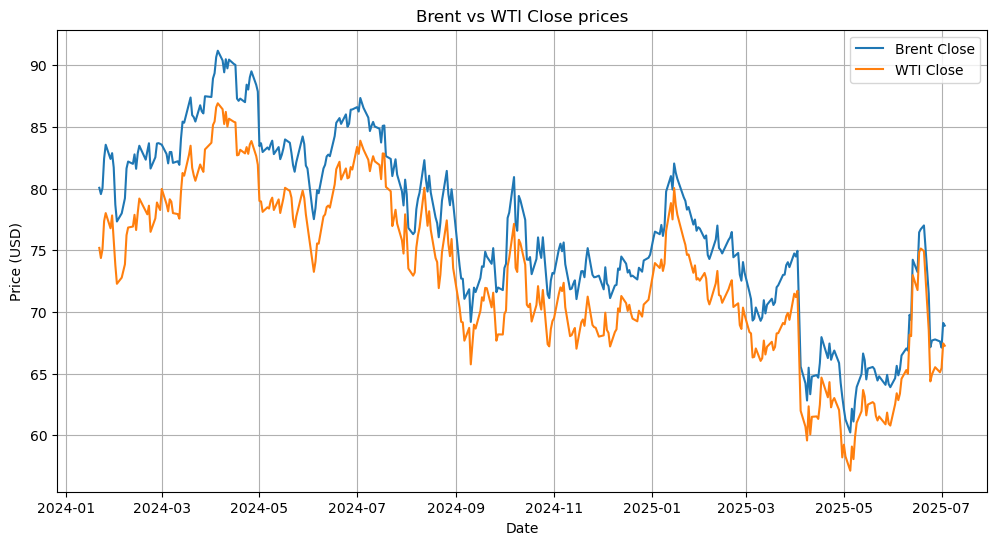

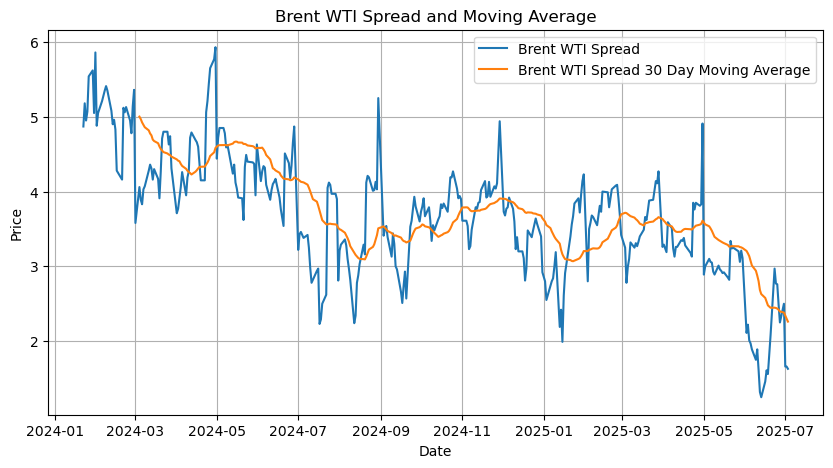

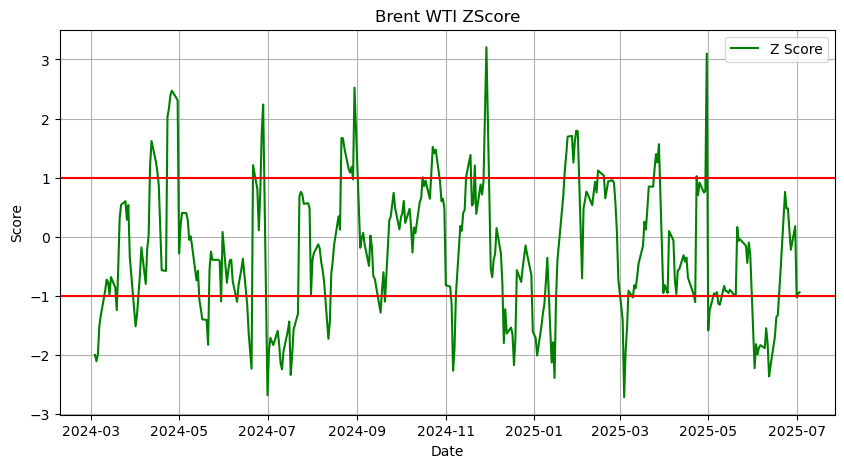

Brent WTI Arbitrage Strategy P&L: 24.00%
Brent WTI Arbitrage Strategy Sharpe Ratio: 2.59


In [121]:
def performance_summary(df, risk_free_rate=0):
    pnl_pct = (df['strategy_cumulative_explicit'].iloc[-1] - 1) * 100
    mean_ret = df['strategy_returns_explicit'].mean()
    std_ret = df['strategy_returns_explicit'].std()
    sharpe = (mean_ret - risk_free_rate) / std_ret * np.sqrt(252)
    print(f"Brent WTI Arbitrage Strategy P&L: {pnl_pct:.2f}%")
    print(f"Brent WTI Arbitrage Strategy Sharpe Ratio: {sharpe:.2f}")

df = get_data()
plot_price_data()
calculate_spread_zscore()
define_signals()
explicit_positions()
returns()
performance_summary(df)